In [1]:
import pandas as pd
import glob
import os
import re

# Specify the folder containing .sc files
SC_FOLDER = "collected_scores"  # Replace with your folder name

# Function to extract identifier from filename
def get_identifier(filename):
    # Split by underscore and take elements between first and third underscore
    parts = filename.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return filename  # fallback if pattern doesn't match

# Function to process a single .sc file
def process_sc_file(filepath):
    # Read the file, skip the first line (SEQUENCE:), use whitespace as separator
    df = pd.read_csv(filepath, delim_whitespace=True, skiprows=1)
    
    # Filter rows that start with "SCORE:"
    df = df[df['SCORE:'] == 'SCORE:']
    
    # Convert total_score to numeric, it's the second column
    total_scores = pd.to_numeric(df.iloc[:, 1])
    
    return total_scores.mean(), total_scores.std()

# Main processing
results = []

# Loop through all .sc files in the specified folder
for filepath in glob.glob(os.path.join(SC_FOLDER, "*.sc")):
    try:
        # Get identifier from filename
        identifier = get_identifier(os.path.basename(filepath))
        
        # Process file
        mean_energy, std_energy = process_sc_file(filepath)
        
        # Store results
        results.append({
            'identifier': identifier,
            'mean_energy': mean_energy,
            'std_energy': std_energy
        })
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")

# Create final dataframe
results_df = pd.DataFrame(results)
results_df.set_index('identifier', inplace=True)
results_df = results_df.reset_index()
results_df[['structure', 'sequence']] = results_df['identifier'].str.split('_',expand=True)



In [2]:
results_df_nonrandom = results_df[results_df['sequence']!='random']
results_df_random = results_df[results_df['sequence']=='random']
results_df_random = results_df_random.drop('std_energy',axis = 1)
results_df_random

,identifier,mean_energy,structure,sequence
2,2jwu_random,4.408650e+02,2jwu,random
4,2fs1_random,7.803006e+07,2fs1,random
5,2kdm_random,3.350380e+02,2kdm,random
6,1pga_random,1.844900e+01,1pga,random
7,2kdl_random,4.686580e+02,2kdl,random
...,...,...,...,...
247,2kdl_random,4.922600e+02,2kdl,random
248,1pga_random,1.088300e+01,1pga,random
249,2jws_random,5.468350e+02,2jws,random
250,2jwu_random,4.240300e+02,2jwu,random


In [3]:
def process_energy_data(df, id_column, energy_column):
    """
    Group DataFrame by identifier, calculate statistics on energy values,
    and keep other columns that are constant within each group.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with identifier and energy columns
    id_column (str): Name of the identifier column
    energy_column (str): Name of the energy column
    
    Returns:
    pandas.DataFrame: Processed DataFrame with one row per identifier
    """
    # Calculate mean and std of energy for each group
    stats_df = df.groupby(id_column)[energy_column].agg(['mean', 'std']).reset_index()
    stats_df.columns = [id_column, 'mean_energy', 'std_energy']
    
    # For columns that are constant within each group, take the first value
    # Get all columns except id_column and energy_column
    other_columns = [col for col in df.columns if col not in [id_column, energy_column]]
    
    # For each group, take the first value of each other column
    # (assuming these values are the same within each group)
    first_values = df.groupby(id_column)[other_columns].first().reset_index()
    
    # Merge the two DataFrames
    result = pd.merge(stats_df, first_values, on=id_column)
    
    return result


In [4]:
results_df_random = process_energy_data(results_df_random,'structure','mean_energy')

In [5]:
results_df_random

,structure,mean_energy,std_energy,identifier,sequence
0,1pga,1.443513e+01,5.559735,1pga_random,random
1,2fs1,7.800171e+07,81301.990795,2fs1_random,random
2,2jws,5.255274e+02,14.068956,2jws_random,random
3,2jwu,4.372465e+02,21.915958,2jwu_random,random
4,2kdl,4.737426e+02,13.253645,2kdl_random,random
5,2kdm,3.336801e+02,12.714594,2kdm_random,random


In [6]:
results_df = pd.concat([results_df_random,results_df_nonrandom])

In [7]:
import numpy as np

In [8]:
np.unique(results_df['sequence'])

array(['GA77', 'GA88', 'GA91', 'GA95', 'GA98', 'GAWT', 'GB77', 'GB88',
       'GB91', 'GB95', 'GB98', 'GBWT', 'random'], dtype=object)

In [9]:
struct_dict = {'2kdl':'GA95','2kdm':'GB95','2jws':'GA88','2jwu':'GB88','1pga':'GBWT','2fs1':'GAWT'}

2kdl
2kdm
2jws
2jwu
1pga


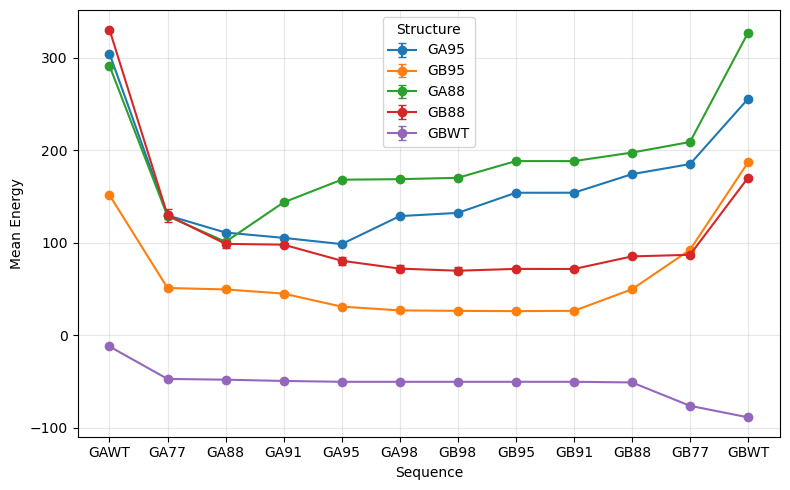

In [10]:
# Plot
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
sequence_order = ['GAWT','GA77','GA88','GA91', 'GA95','GA98','GB98', 'GB95','GB91','GB88', 'GB77','GBWT']

for struct in ['2kdl', '2kdm','2jws','2jwu','1pga']:
    print(struct)
    subset = results_df[results_df['structure'] == struct].set_index('sequence')
    means = [subset.loc[seq, 'mean_energy'] if seq in subset.index else None for seq in sequence_order]
    stds = [subset.loc[seq, 'std_energy'] if seq in subset.index else None for seq in sequence_order]
    plt.errorbar(sequence_order, np.array(means) , yerr=stds, fmt='o-', capsize=3, label=struct_dict[struct])

plt.xlabel('Sequence')
plt.ylabel('Mean Energy')
plt.legend(title='Structure')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

2kdl
2kdm
2jws
2jwu


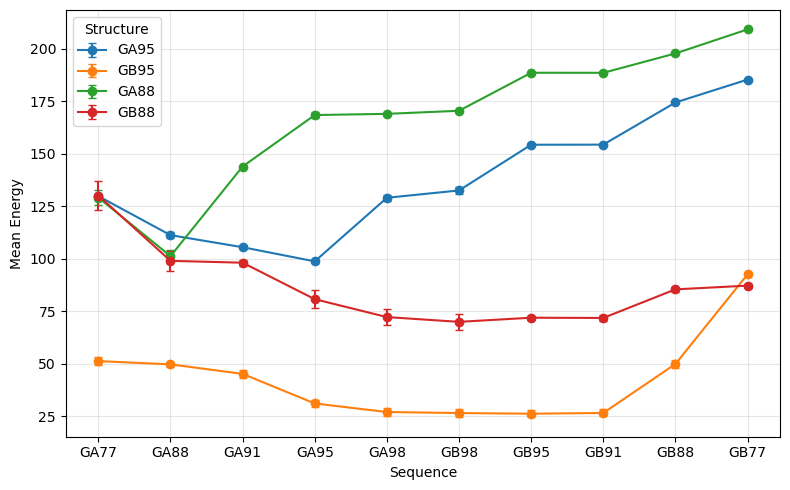

In [12]:
import numpy as np
import matplotlib.pyplot as plt
struct_dict = {'2kdl':'GA95','2kdm':'GB95','2jws':'GA88','2jwu':'GB88','1pga':'GBWT','2fs1':'GAWT'}
plt.figure(figsize=(8, 5))
# Removed 'GAWT' and 'GBWT' from the sequence order
sequence_order = ['GA77','GA88','GA91', 'GA95','GA98','GB98', 'GB95','GB91','GB88', 'GB77']

for struct in ['2kdl', '2kdm','2jws','2jwu']:
    print(struct)
    subset = results_df[results_df['structure'] == struct].set_index('sequence')
    means = [subset.loc[seq, 'mean_energy'] if seq in subset.index else None for seq in sequence_order]
    stds = [subset.loc[seq, 'std_energy'] if seq in subset.index else None for seq in sequence_order]
    plt.errorbar(sequence_order, np.array(means), yerr=stds, fmt='o-', capsize=3, label=struct_dict[struct])

plt.xlabel('Sequence')
plt.ylabel('Mean Energy')
plt.legend(title='Structure')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

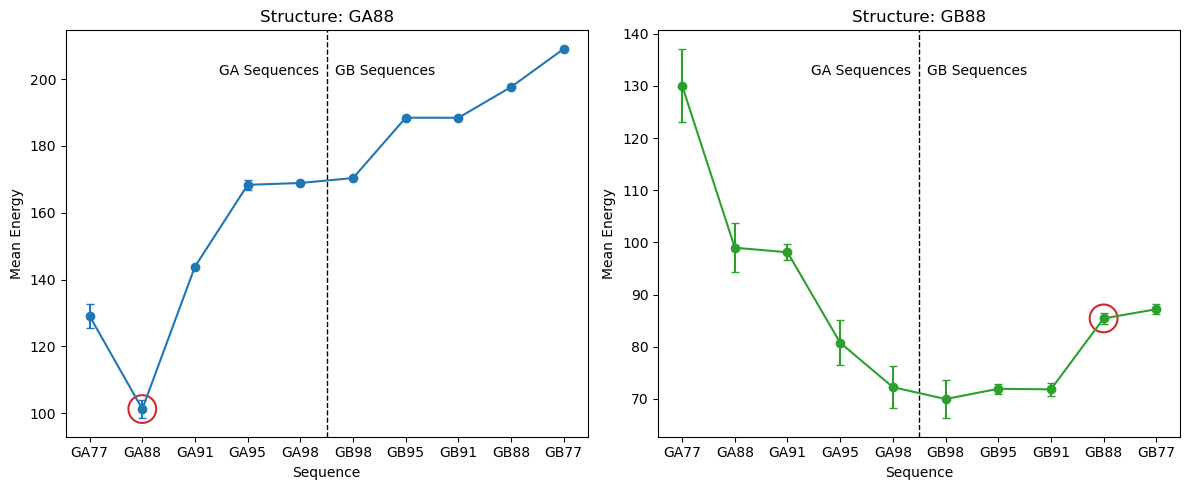

In [68]:
import numpy as np
import matplotlib.pyplot as plt
struct_dict = {'2kdl':'GA95','2kdm':'GB95','2jws':'GA88','2jwu':'GB88','1pga':'GBWT','2fs1':'GAWT'}
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Removed 'GAWT' and 'GBWT' from the sequence order
sequence_order = ['GA77','GA88','GA91', 'GA95','GA98','GB98', 'GB95','GB91','GB88', 'GB77']
# First subplot for GA95 (2kdl)
color = 'C0'
struct = '2jws'  # GA95
subset = results_df[results_df['structure'] == struct].set_index('sequence')
means = [subset.loc[seq, 'mean_energy'] if seq in subset.index else None for seq in sequence_order]
stds = [subset.loc[seq, 'std_energy'] if seq in subset.index else None for seq in sequence_order]
ax1.errorbar(sequence_order, np.array(means), yerr=stds, fmt='-o', capsize=3, label=struct_dict[struct],color=color)
ax1.set_xlabel('Sequence')
ax1.set_ylabel('Mean Energy')
ax1.set_title(f'Structure: {struct_dict[struct]}')
native_seq_index = sequence_order.index(struct_dict[struct])
ax1.scatter([native_seq_index],[means[native_seq_index]],facecolors='none',edgecolor = 'C3',s=400,lw = 1.5)
ax1.axvline(4.5,linestyle='--',color='black',lw=1)
y_min, y_max = ax1.get_ylim()
subplot_height = y_max - y_min
ax1.text(x=5.6, y=y_min + 0.9 * subplot_height, 
        s="GB Sequences", 
        ha='center', va='center')
ax1.text(x=3.4, y=y_min + 0.9 * subplot_height, 
        s="GA Sequences", 
        ha='center', va='center')
# Second subplot for GB95 (2kdm)
color = 'C2'
struct = '2jwu'  # GB95
subset = results_df[results_df['structure'] == struct].set_index('sequence')
means = [subset.loc[seq, 'mean_energy'] if seq in subset.index else None for seq in sequence_order]
stds = [subset.loc[seq, 'std_energy'] if seq in subset.index else None for seq in sequence_order]
ax2.errorbar(sequence_order, np.array(means), yerr=stds, fmt='-o', capsize=3, label=struct_dict[struct], color=color)
ax2.set_xlabel('Sequence')
ax2.set_ylabel('Mean Energy')
ax2.set_title(f'Structure: {struct_dict[struct]}')
native_seq_index = sequence_order.index(struct_dict[struct])
ax2.scatter([native_seq_index],[means[native_seq_index]],facecolors='none',edgecolor = 'C3',s=400,lw = 1.5)
ax2.axvline(4.5,linestyle='--',color='black',lw=1)
y_min, y_max = ax2.get_ylim()
subplot_height = y_max - y_min
ax2.text(x=5.6, y=y_min + 0.9 * subplot_height, 
        s="GB Sequences", 
        ha='center', va='center')
ax2.text(x=3.4, y=y_min + 0.9 * subplot_height, 
        s="GA Sequences", 
        ha='center', va='center')
plt.tight_layout()
plt.savefig('ga95gb95.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

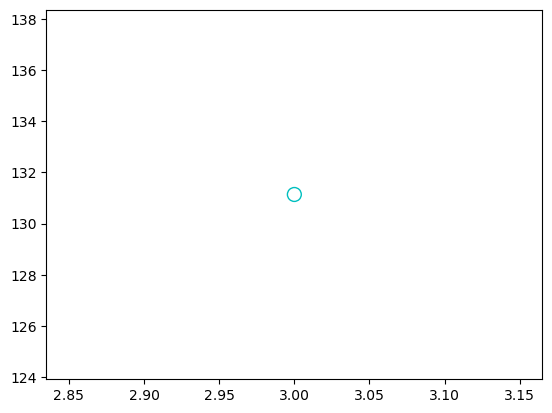

In [25]:
native_seq_index = sequence_order.index('GA95')
plt.scatter([native_seq_index],[means[native_seq_index]+100],facecolors='none',edgecolor = 'c',s=100)